In [ ]:
from test_ahp_lif_torch import *
from rockpool.nn.modules.torch.ahp_lif_torch import aLIFTorch
from rockpool.parameters import Constant
import torch

In [ ]:
N_neurons = 3
N_syn = 2
n_batchs = 10
T = 20

# w_ahp = Constant(torch.ones(1, N_neurons))
w_ahp = Constant(torch.ones(N_neurons, N_syn))

for n in range(N_neurons):

    w_ahp[n, :] *= -(n + 1)

print(w_ahp)

In [ ]:
mod = aLIFTorch(shape=(N_syn * N_neurons, N_neurons), w_ahp=w_ahp, bias=Constant(0))

In [ ]:
input = torch.zeros(n_batchs, T, N_syn * N_neurons)
input[:, 0, :] = 1

In [ ]:
mod.reset_state()
out, st, rd = mod(input, record=True)

In [ ]:
print(rd.keys())

In [ ]:
print(rd["iahp"][:, 19, 1])

In [ ]:
print(rd["vmem"][:, 19, 0])

In [ ]:
print(rd["vmem"][:, 19, 1])

In [ ]:
print(rd["vmem"][:, 19, 2])

In [ ]:
torch.all(rd["vmem"][:, 1:, 0] > rd["vmem"][:, 1:, 1])

In [ ]:
torch.all(rd["vmem"][:, 1:, 1] > rd["vmem"][:, 1:, 2])

In [ ]:
N_neurons = 3
N_syn = 1
n_batchs = 10
T = 20

w_ahp = -Constant(torch.ones(N_neurons, N_syn))
tau_ahp = torch.zeros((N_neurons, N_syn), requires_grad=False)

for n in range(N_neurons):

    tau_ahp[n, :] = (n + 1) * 0.2

print(tau_ahp)
# tau_ahp = torch.tensor(tau_ahp, requires_grad=False)
print(tau_ahp.grad_fn)

In [ ]:
input = torch.zeros(n_batchs, T, N_syn * N_neurons)
input[:, 0, :] = 100
mod = ahp_LIFTorch(
    shape=(N_syn * N_neurons, N_neurons),
    has_ahp=True,
    w_ahp=w_ahp,
    tau_ahp=tau_ahp,
    bias=Constant(0),
)
print(tau_ahp)

In [ ]:
mod.reset_state()
out, st, rd = mod(input, record=True)

In [ ]:
torch.all(rd["iahp"][:, -1, 0] < rd["iahp"][:, -1, 2])

tensor(1., grad_fn=<SumBackward0>)


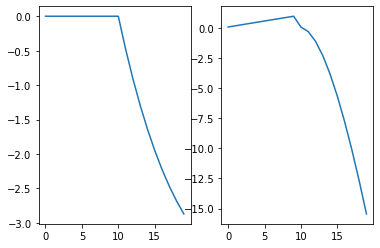

In [23]:
from rockpool.nn.modules.torch.ahp_lif_torch import aLIFTorch
from rockpool.nn.modules.torch.lif_torch import LIFTorch
from rockpool.parameters import Constant
import matplotlib.pyplot as plt
import torch
import numpy as np

n_synapses = 1
n_neurons = 1
n_batches = 1
T = 20
tau_mem = torch.rand(n_neurons)
# tau_mem  = 0.02
tau_syn = 0.02
bias = torch.ones(n_neurons) * 0.1
dt = 1e-3
w_ahp = -0.5
mod = aLIFTorch(
    shape=(n_synapses * n_neurons, n_neurons),
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    threshold=1.0,
    bias=bias,
    dt=dt,
    w_ahp=Constant(w_ahp),
    noise_std=0.0,
)

input_data = torch.zeros(n_batches, T, n_synapses * n_neurons, requires_grad=True)

# - Test Rockpool interface
out, ns, rd = mod(input_data, record=True)

out.sum().backward()
# print(ns["isyn"])
# print(rd["isyn"])
isyn = rd["isyn"].detach().numpy()
vmem = rd["vmem"].detach().numpy()

print(out.sum())
# print(test)
plt.subplot(121)
plt.plot(isyn[0, :, 0, 0])
plt.subplot(122)
plt.plot(
    vmem[
        0,
        :,
        0,
    ]
)

assert torch.all(ns["isyn"] <= 0)
assert torch.all(rd["isyn"] <= 0)
assert torch.all(rd["vmem"][:, 0] == 0.1)  # match bias in the fist timestep
assert torch.all(
    rd["vmem"][:, 1] == 0.1 * torch.exp(-dt / tau_mem) + 0.1
)  # decay one timestep + bias

# assert bias has gradients
assert not torch.all(mod.bias.grad == 0)

In [24]:
from rockpool.nn.modules.torch.ahp_lif_torch import aLIFTorch
import torch

n_synapses = 1
n_neurons = 1
n_batches = 1
T = 20
tau_mem = torch.rand(n_neurons)
tau_syn = 0.02
bias = torch.ones(n_neurons) * 0.1
w_ahp = -0.5

dt = 1e-3

mod = aLIFTorch(
    shape=(n_synapses * n_neurons, n_neurons),
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    threshold=1.0,
    bias=bias,
    dt=dt,
    w_ahp=Constant(w_ahp),
    noise_std=0.0,
)

# - Generate some data
input_data = torch.zeros(n_batches, T, n_synapses * n_neurons, requires_grad=True)

# - Test Rockpool interface
out, ns, rd = mod(input_data, record=True)

out.sum().backward()

assert torch.all(ns["isyn"] <= 0)
assert torch.all(rd["isyn"] <= 0)
assert torch.all(rd["vmem"][:, 0] == 0.1)  # match bias in the fist timestep
assert torch.all(
    rd["vmem"][:, 1] == 0.1 * torch.exp(-dt / tau_mem) + 0.1
)  # decay one timestep + bias

# assert bias has gradients
assert not torch.all(mod.bias.grad == 0)